# Netflix Subscriptions Forecasting

### Importing Necessay Python libraries 

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## Load the Data

In [232]:
# reading the data
data = pd.read_csv("C:/Users/deepa/Downloads/Netflix-Subscriptions (1).csv")

In [233]:
data.head()

,Time Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


## Preview data

In [234]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time Period  42 non-null     object
 1   Subscribers  42 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 804.0+ bytes
None


In [235]:
print(data.describe())

        Subscribers
count  4.200000e+01
mean   1.304243e+08
std    6.891896e+07
min    3.424000e+07
25%    6.722500e+07
50%    1.216250e+08
75%    2.015325e+08
max    2.383900e+08


## Check for missing values

In [236]:
print(data.isnull().sum())

Time Period    0
Subscribers    0
dtype: int64


In [237]:
data['Time Period'] = pd.to_datetime(data['Time Period'], 
                                     format='%d/%m/%Y')

In [238]:

print(data.head())

  Time Period  Subscribers
0  2013-04-01     34240000
1  2013-07-01     35640000
2  2013-10-01     38010000
3  2014-01-01     41430000
4  2014-04-01     46130000


In [239]:
print(data.columns)


Index(['Time Period', 'Subscribers'], dtype='object')


## Now let’s have a look at the quarterly subscription growth of Netflix:

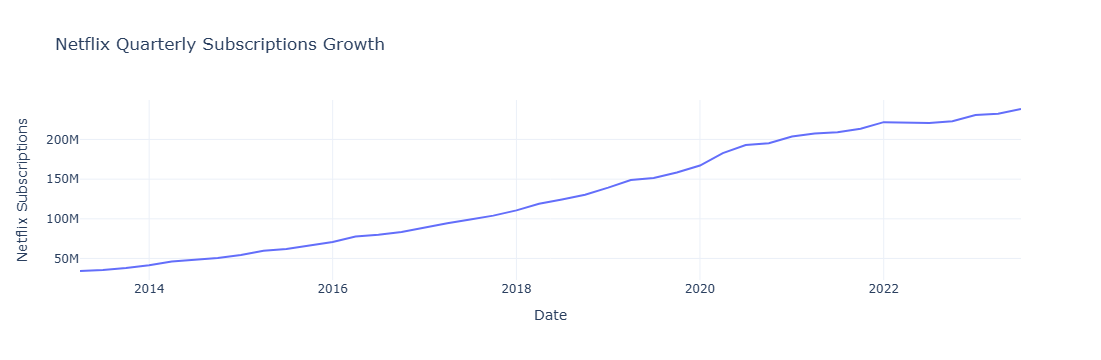

In [240]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Time Period'],
                         y=data['Subscribers'],
                         mode='lines', name='Subscribers'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                  xaxis_title='Date',
                  yaxis_title='Netflix Subscriptions')
fig.show()

## Calculate the quarterly growth rate

In [241]:
data['Quarterly Growth Rate'] = data['Subscribers'].pct_change() * 100

## Create a new column for bar color (green for positive growth, red for negative growth)

In [242]:
data['Bar Color'] = data['Quarterly Growth Rate'].apply(lambda x: 'blue' if x > 0 else 'red')

## Plot the quarterly growth rate using bar graphs

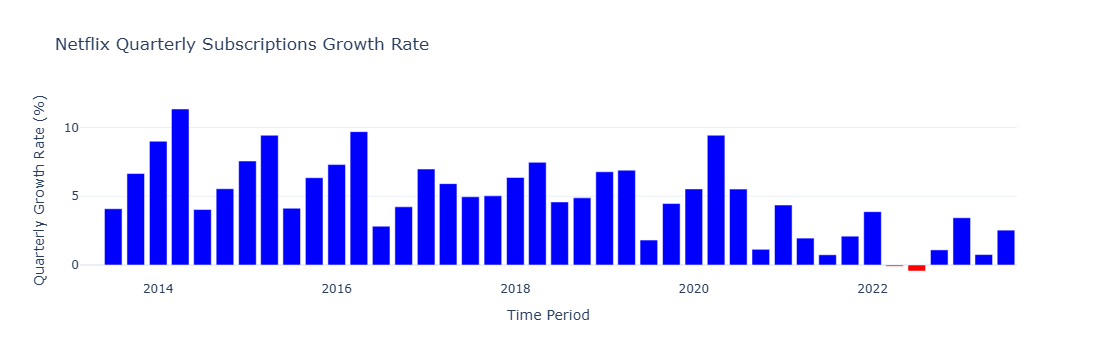

In [243]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Time Period'],
    y=data['Quarterly Growth Rate'],
    marker_color=data['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)')
fig.show()

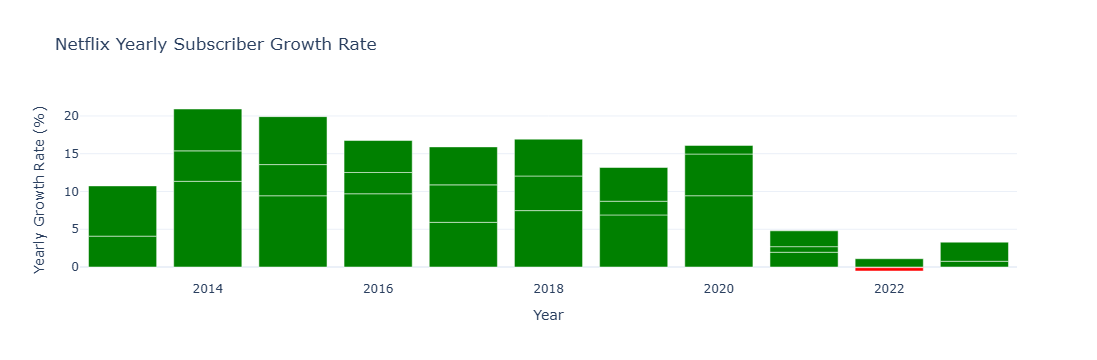

In [244]:
# Calculate the yearly growth rate
data['Year'] = data['Time Period'].dt.year
yearly_growth = data.groupby('Year')['Subscribers'].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar Color'] = yearly_growth.apply(lambda x: 'green' if x > 0 else 'red')

# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Year'],
    y=yearly_growth,
    marker_color=data['Bar Color'],
    name='Yearly Growth Rate'
))
fig.update_layout(title='Netflix Yearly Subscriber Growth Rate',
                  xaxis_title='Year',
                  yaxis_title='Yearly Growth Rate (%)')
fig.show()

## Using ARIMA for Forecasting Netflix Quarterly Subscriptions

In [245]:
time_series = data.set_index('Time Period')['Subscribers']

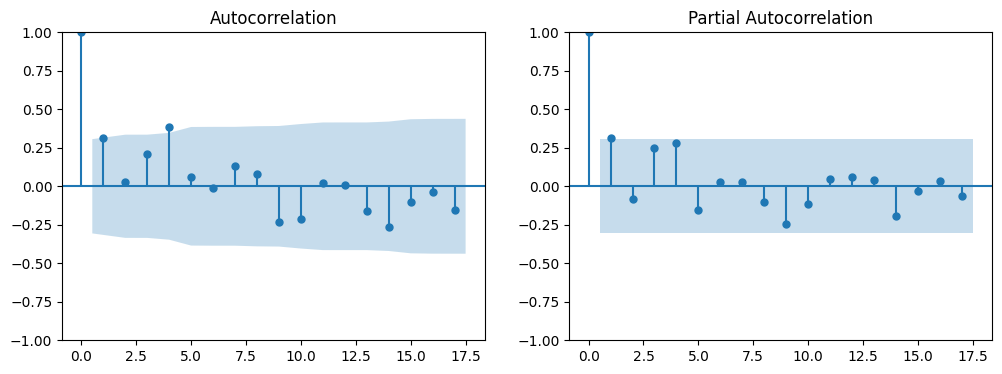

In [246]:
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [247]:
p, d, q = 1, 1, 1
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Thu, 26 Dec 2024   AIC                           1351.986
Time:                        19:27:13   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.760      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

C:\Users\deepa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\deepa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\deepa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



In [248]:
future_steps = 5
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)

## Plot the original data and predictions

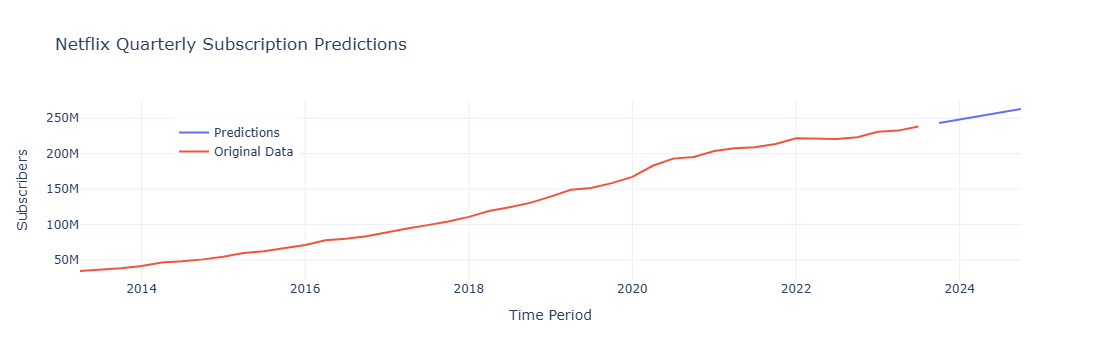

In [249]:
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='Netflix Quarterly Subscription Predictions',
                  xaxis_title='Time Period',
                  yaxis_title='Subscribers',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()

## Netflix Subscriber Growth

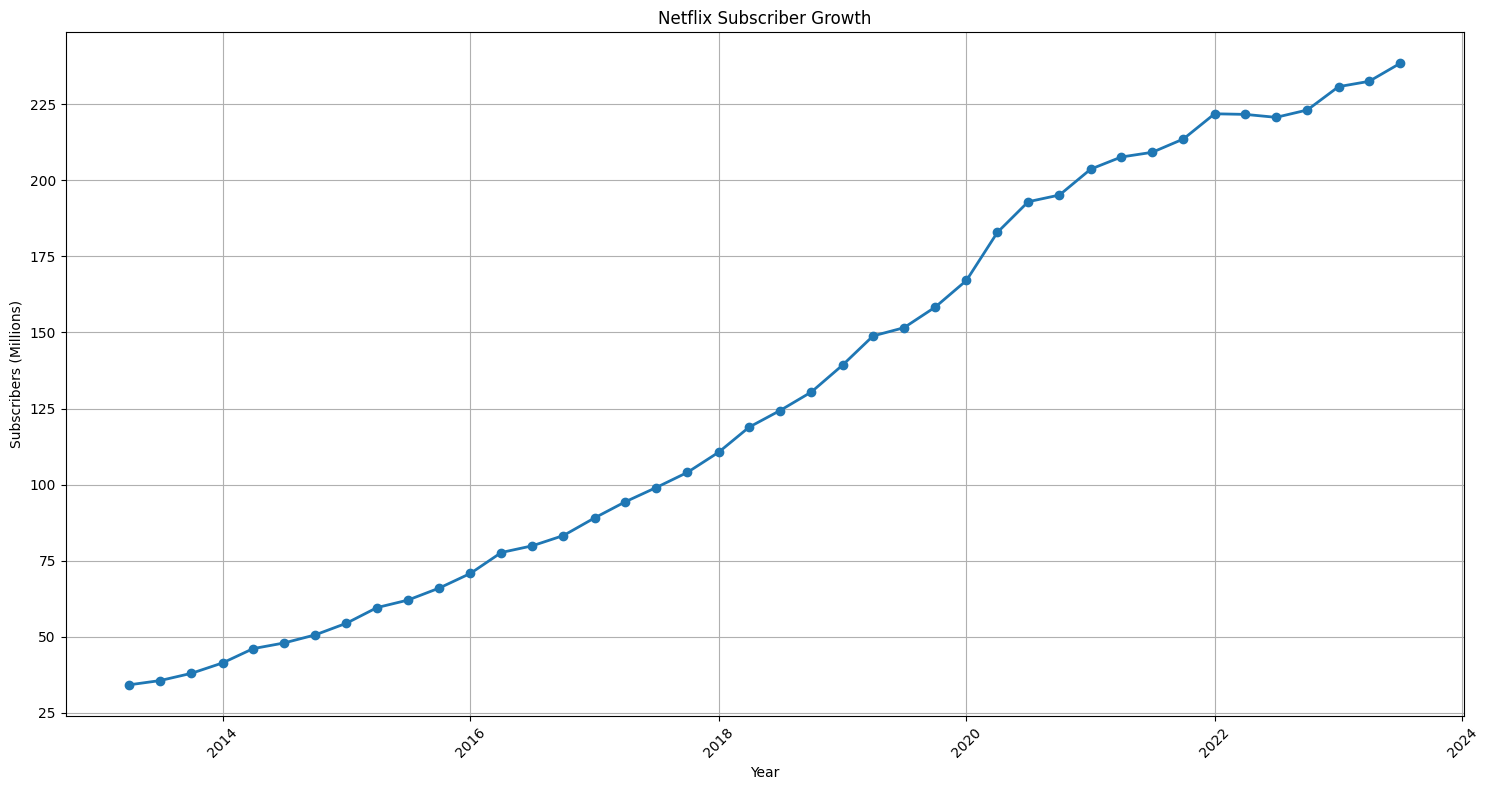

In [250]:
plt.figure(figsize=(15, 8))
plt.plot(data['Time Period'], data['Subscribers'] / 1e6, linewidth=2, marker='o')
plt.title('Netflix Subscriber Growth')
plt.xlabel('Year')
plt.ylabel('Subscribers (Millions)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##  Growth metrics

In [251]:
total_growth = ((data['Subscribers'].iloc[-1] / data['Subscribers'].iloc[0]) - 1) * 100
years = (data['Time Period'].iloc[-1] - data['Time Period'].iloc[0]).days / 365
cagr = (pow(data['Subscribers'].iloc[-1] / data['Subscribers'].iloc[0], 1/years) - 1) * 100

## Calculate growth metrics

In [252]:
print(f"""
Analysis Period: {data['Time Period'].min().strftime('%B %Y')} to {data['Time Period'].max().strftime('%B %Y')}
Starting subscribers: {data['Subscribers'].iloc[0]:,.0f}
Current subscribers: {data['Subscribers'].iloc[-1]:,.0f}
Total growth: {total_growth:.1f}%
CAGR: {cagr:.1f}%
""")


Analysis Period: April 2013 to July 2023
Starting subscribers: 34,240,000
Current subscribers: 238,390,000
Total growth: 596.2%
CAGR: 20.8%



In [253]:
data['Time Period'] = pd.to_datetime(data['Time Period'], errors='coerce').dt.year


data.dropna(subset=['Time Period', 'Subscribers'], inplace=True)

print(data.dtypes)  

Time Period                int32
Subscribers                int64
Quarterly Growth Rate    float64
Bar Color                 object
Year                       int32
dtype: object


## Define features and target

In [254]:
X = data[['Time Period']] 
y = data['Subscribers']    


##  Split Data into Training and Testing Sets

In [255]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.dtypes)
print(X_test.dtypes)


Time Period    int32
dtype: object
Time Period    int32
dtype: object


## Train the Model

In [256]:
from sklearn.linear_model import LinearRegression

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

##  Make Predictions

In [257]:
# Predict using the test set
y_pred = model.predict(X_test)

# Print predictions for verification
print(y_pred)


[1.52154730e+08 8.62990645e+07 6.43471759e+07 1.52154730e+08
 4.23952873e+07 2.39962285e+08 1.30202842e+08 1.74106619e+08
 1.74106619e+08]


## Visualize Actual vs Predicted Values

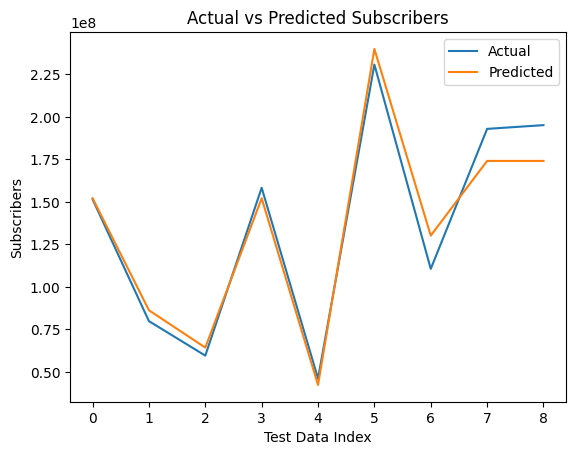

In [258]:
import matplotlib.pyplot as plt

# Visualize actual vs. predicted values
plt.plot(y_test.values, label='Actual') 
plt.plot(y_pred, label='Predicted')     
plt.legend()
plt.title('Actual vs Predicted Subscribers')
plt.xlabel('Test Data Index')
plt.ylabel('Subscribers')
plt.show()
